# Import Library

In [ ]:
!pip install --quiet torchviz

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install torchsummary

# Data 생성부

* input -
* output: x (tensor), y (tensor) = y_ideal + noise

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt


In [ ]:
def gen_xy():
    x=np.linspace(-10,10,100)
    y_ideal = 1.8 * x +32.
    y= y_ideal + 5. * np.random.randn((100))

    return x,y,y_ideal


### check

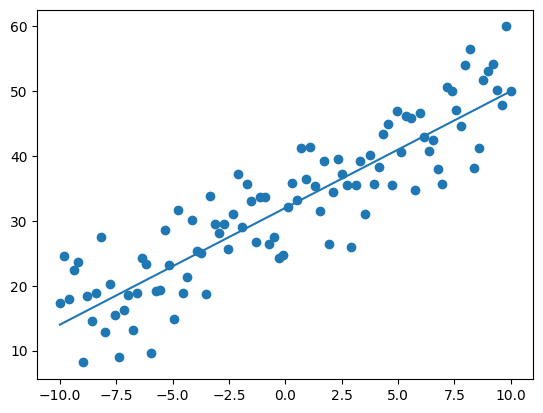

In [ ]:
x,y, y_ideal = gen_xy()

plt.plot(x,y_ideal)
plt.scatter(x,y)

### tensor로 변환 (+shape)

In [ ]:
x=torch.tensor(x).float()
y=torch.tensor(y).float()

x=x.reshape(-1,1)
y=y.reshape(-1,1)

print(x.shape)
print(y.shape)


torch.Size([100, 1])
torch.Size([100, 1])


<ipython-input-13-59b5c5ba969c>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x).float()
<ipython-input-13-59b5c5ba969c>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y).float()


# Model

In [ ]:
from torch.nn import Module, init, Linear, Parameter, ReLU
from torch import optim

In [ ]:
Linear.mro()


[torch.nn.modules.linear.Linear, torch.nn.modules.module.Module, object]

In [ ]:
class DsANN(Module): #custom module

  def __init__(self,
               n_in_f, #input vector의 차원수
               n_out_f #output vector의 차원수
               ):
    #def __init__(self,*args):
     super().__init__()# required!

     self.linear0 = Linear(n_in_f, 32)
     self.relu0 = ReLU()

     self.linear1 = Linear(32, 32)
     self.relu1 = ReLU()

     self.linear2 = Linear(32, n_out_f)

     with torch.no_grad():
        init.constant_(self.linear0.bias, 0.)
        init.xavier_uniform_(self.linear0.weight)

  def forward(self,x):
        x = self.linear0(x)
        x = self.relu0(x)
        x = self.linear1(x)
        x = self.relu1(x)
        y = self.linear2(x)
        return y

model = DsANN(1,1)

### check:Parameters

In [ ]:
# for idx, c in enumerate(model.named_parameters()):
for idx, c in enumerate(model.parameters()):
   print(idx, c.shape)

0 torch.Size([32, 1])
1 torch.Size([32])
2 torch.Size([32, 32])
3 torch.Size([32])
4 torch.Size([1, 32])
5 torch.Size([1])


### check: children

In [ ]:
#for idx, cl in enumerate(model.children()):
for idx, cl in enumerate(model.children()):
  print(idx, cl)

0 Linear(in_features=1, out_features=32, bias=True)
1 ReLU()
2 Linear(in_features=32, out_features=32, bias=True)
3 ReLU()
4 Linear(in_features=32, out_features=1, bias=True)


### check: modules

In [ ]:
for idx, modu in enumerate(model.modules()):
  print(idx, modu)

0 DsANN(
  (linear0): Linear(in_features=1, out_features=32, bias=True)
  (relu0): ReLU()
  (linear1): Linear(in_features=32, out_features=32, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=32, out_features=1, bias=True)
)
1 Linear(in_features=1, out_features=32, bias=True)
2 ReLU()
3 Linear(in_features=32, out_features=32, bias=True)
4 ReLU()
5 Linear(in_features=32, out_features=1, bias=True)


In [ ]:
x = x.reshape(-1,1)
x.shape

torch.Size([100, 1])

In [ ]:

pred = model(x)
pred.shape


torch.Size([100, 1])

In [ ]:
pred = Linear(1,1)(x)
pred.shape

torch.Size([100, 1])

In [ ]:
x.shape

torch.Size([100, 1])

In [ ]:
y.shape

torch.Size([100, 1])

In [ ]:
y=y.reshape(-1,1)
y.shape

torch.Size([100, 1])

In [ ]:
pred.shape

torch.Size([100, 1])

# Loss

In [ ]:
from torch.nn import MSELoss

loss_fnc = MSELoss()

l = loss_fnc(pred, y)
l

tensor(1195.3796, grad_fn=<MseLossBackward0>)

#Training Loop

In [ ]:
from torch import optim


def training_loop(
    x, y,
    model,
    lr,
    n_epochs,
    ):

  model.train()#train모드
  #model.eval()#evaluation모드, 안 넣어도 동작하는 데 아무 문제 없음
  optimizer = optim.SGD(
    model.parameters(),
    lr = lr,
  )
  print(n_epochs)

  for epoch in range(n_epochs):
    pred = model(x)
    l = loss_fnc(pred, y)
    if torch.isinf(l).any():#error가 무한대로 튀면, 또 많은 error들이 무한대로 튀면
      print('Error: diverge!')
      break

    optimizer.zero_grad()#optimizer에서 관리하는 것들을 싹 다 처리
    l.backward()#back pripagation
    optimizer.step()

    if epoch % 1000 == 0:
      print(f'Epoch {epoch}: Loss {float(l):0.4f}')

  return model



In [ ]:
print(type(x))
print(type(y))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


#Train

In [ ]:
model = DsANN(1,1)
model = training_loop(
    x,y,
    model,
    1e-3,
    7000,
)

7000
Epoch 0: Loss 1188.4923
Epoch 1000: Loss 24.9589
Epoch 2000: Loss 24.6354
Epoch 3000: Loss 24.7628
Epoch 4000: Loss 24.4904
Epoch 5000: Loss 24.6377
Epoch 6000: Loss 24.6053


# Evaluation

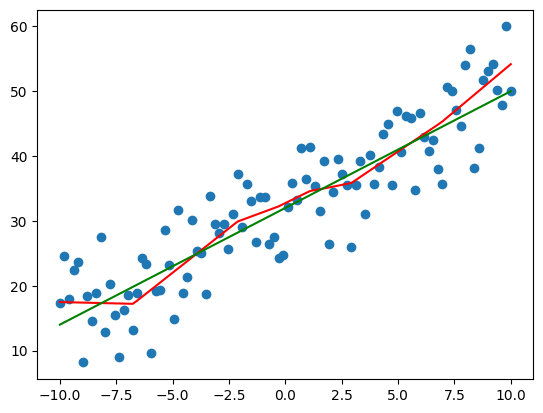

In [ ]:
pred=model(x)

plt.scatter(x.detach().numpy(), y.detach().numpy())
plt.plot(x.detach().numpy(), pred.detach().numpy(), color = 'r')
plt.plot(x.detach().numpy(), y_ideal, color = 'g')

In [ ]:
model = training_loop(
    x,y,
    Linear(1,1),
    1e-3,
    7000,
)


7000
Epoch 0: Loss 1231.0238
Epoch 1000: Loss 46.4766
Epoch 2000: Loss 27.8687
Epoch 3000: Loss 27.5292
Epoch 4000: Loss 27.5230
Epoch 5000: Loss 27.5229
Epoch 6000: Loss 27.5229


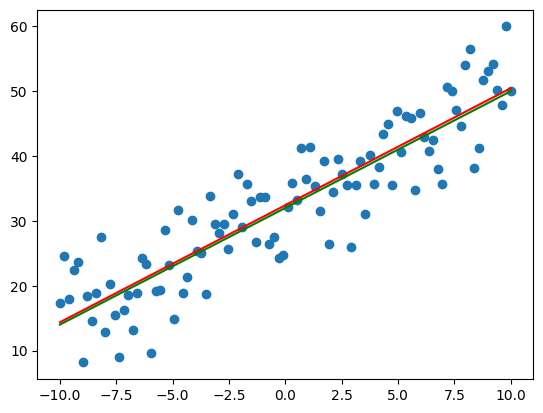

In [ ]:
pred = model(x)

plt.scatter(x.detach().numpy(), y.detach().numpy())
plt.plot(x.detach().numpy(), pred.detach().numpy(), color = 'r')
plt.plot(x.detach().numpy(), y_ideal, color = 'g')